<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Regression Challenge
Notebook I

--- 
#### Data Cleaning & EDA


This notebook serves as the starting point of the AMES housing price prediction project. It contains content as follows:

- [Data Cleaning](#Data-Cleaning)
- [Initial Exploratory Data Analysis](#Initial-EDA)
- [Visualizations](#Visualizations)
- [Initial Feature Engineering](#Initial-Feature-Engineering)

The result of the above steps are clean datasets for both training and testing data that will be used for later stages such as feature selections, modeling and findings, which are included in separate notebooks.

---

### Importing data and necessary libaries/ modules.
To have a better overview of the training data, I set to display all the rows and columns.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# credit to https://dev.to/chanduthedev/how-to-display-all-rows-from-data-frame-using-pandas-dha
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

train = pd.read_csv('../datasets/train.csv')
train.head()

test = pd.read_csv('../datasets/test.csv')

In [3]:
train.shape

(2051, 81)

With 81 columns included, I know that I definitely need to trim down some columns to make a more efficient model.

### Data Cleaning

### Formatting and copying
Here I'm formatting all the column names into lower cases and removing the spaces per my personal habits. Understand that whatever I did on my training data I will need to apply it to the test data too to align with the model, I also add the same code for test data. Also I'm making a copy of the original datasets so I always have something to revert to in case needed.

In [4]:
train.columns = [column.lower().replace(' ', '_') for column in train.columns]
df = train.copy()

test.columns = [column.lower().replace(' ', '_') for column in test.columns]
df_test = test.copy()

### Checking nulls and imputing

I choose to only show those with nulls instead of showing all 81 columns.

In [5]:
null_counts = df.isnull().sum()

In [6]:
null_columns = null_counts[null_counts > 0].sort_values(ascending = False)
null_columns

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_yr_blt      114
garage_cond        114
garage_qual        114
garage_finish      114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmt_cond           55
bsmt_qual           55
bsmtfin_type_1      55
mas_vnr_type        22
mas_vnr_area        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_cars          1
bsmtfin_sf_1         1
bsmtfin_sf_2         1
bsmt_unf_sf          1
garage_area          1
total_bsmt_sf        1
dtype: int64

As you can see, some columns have great amount of null values. I decide to drop the columns with over 80% missing values because the data does not have enough variance to influence linear regression models.

In [7]:
null_count_percent = pd.DataFrame(null_columns, index = null_columns.index, columns = ['count'])
null_count_percent['percent'] = null_count_percent['count']/df.shape[0]
null_count_percent['percent'][null_count_percent['percent'] > 0.8]

pool_qc         0.995612
misc_feature    0.968308
alley           0.931741
fence           0.804973
Name: percent, dtype: float64

In [8]:
df.drop(columns = ['pool_qc', 'misc_feature', 'alley', 'fence'], inplace = True)

df_test.drop(columns = ['pool_qc', 'misc_feature', 'alley', 'fence'], inplace = True)

In [9]:
df.shape

df_test.shape

(878, 76)

From 81 to 77! Baby steps. Now I go on and examine the rest of the list. One thing I noticed that is fireplace quality which has 1000 null values. Imagine the city of Ames in Iowa, I would think fireplace is important for their winters. Therefore I would like to keep the columns as much as I can. I decide to look into details. 

In [10]:
# credit to https://chrisalbon.com/python/data_wrangling/pandas_list_unique_values_in_column/
df.fireplace_qu.unique()

array([nan, 'TA', 'Gd', 'Po', 'Ex', 'Fa'], dtype=object)

The values are all ordinal categorical except for the null ones, by referencing the data dictionary I also noticed that there was a "NA" value for the feature that did not appear in the column, which makes me think that maybe those missing values are just houses without any fireplaces. I verify my hyothesis by looking at another column: number of fireplaces.

In [11]:
df[df.fireplaces == 0]['fireplace_qu'].unique()

array([nan], dtype=object)

In [12]:
df['fireplace_qu']= df['fireplace_qu'].fillna('NA')

df_test['fireplace_qu']= df_test['fireplace_qu'].fillna('NA')

The above verified my hypothesis: the values are not missing, they should just be zero (or the categorical value shown in the data dictionary). So I filled the missing value with "NA". Use this as an inspiration, I'm grouping these features into: garage, basement and others. Start with garage.

Same happens to garage-related categorical features except for one row, which I list as below.

In [13]:
df[df.garage_finish.isnull()][~df.garage_type.isnull()]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice
1712,2237,910201180,70,RM,50.0,9060,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NA,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,0,3,2007,WD,150909


For this row, I would just fill in the missing values with the most frequent value of a categorical feature and the median of a numerical feature.

In [14]:
df.garage_cond.value_counts()

TA    1868
Fa      47
Gd      12
Po       8
Ex       2
Name: garage_cond, dtype: int64

In [15]:
df.garage_qual.value_counts()

TA    1832
Fa      82
Gd      18
Ex       3
Po       2
Name: garage_qual, dtype: int64

In [16]:
df.garage_finish.value_counts()

Unf    849
RFn    579
Fin    509
Name: garage_finish, dtype: int64

In [17]:
df.garage_yr_blt.describe()

count    1937.000000
mean     1978.707796
std        25.441094
min      1895.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2207.000000
Name: garage_yr_blt, dtype: float64

In [18]:
df.garage_cars.describe()

count    2050.000000
mean        1.776585
std         0.764537
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: garage_cars, dtype: float64

In [19]:
df.garage_area.describe()

count    2050.000000
mean      473.671707
std       215.934561
min         0.000000
25%       319.000000
50%       480.000000
75%       576.000000
max      1418.000000
Name: garage_area, dtype: float64

In [20]:
df.loc[1712, 'garage_cond'] = 'TA'
df.loc[1712, 'garage_qual'] = 'TA'
df.loc[1712, 'garage_finish'] = 'Unf'
df.loc[1712, 'garage_yr_blt'] = 1979
df.loc[1712, 'garage_cars'] = 2
df.loc[1712, 'garage_area'] = 474

I then fill all the missing data in garage-related features with NA and for garage year built, I would impute with the year sold as later when I engineer the features, I can substract it to zero.

In [21]:
df.garage_cond = df.garage_cond.fillna('NA')
df.garage_qual = df.garage_qual.fillna('NA')
df.garage_finish = df.garage_finish.fillna('NA')
df.garage_type = df.garage_type.fillna('NA')
df.garage_yr_blt = df.garage_yr_blt.fillna(df.yr_sold)

df_test.garage_cond = df_test.garage_cond.fillna('NA')
df_test.garage_qual = df_test.garage_qual.fillna('NA')
df_test.garage_finish = df_test.garage_finish.fillna('NA')
df_test.garage_type = df_test.garage_type.fillna('NA')
df_test.garage_yr_blt = df_test.garage_yr_blt.fillna(df_test.yr_sold)

Now on to basement. I will focus first on columns with larger numbers of missing values.

In [22]:
df.bsmt_exposure.value_counts()

No    1339
Av     288
Gd     203
Mn     163
Name: bsmt_exposure, dtype: int64

In [23]:
df.bsmtfin_type_2.value_counts()

Unf    1749
Rec      80
LwQ      60
BLQ      48
ALQ      35
GLQ      23
Name: bsmtfin_type_2, dtype: int64

In [24]:
df.bsmtfin_type_1.value_counts()

GLQ    615
Unf    603
ALQ    293
BLQ    200
Rec    183
LwQ    102
Name: bsmtfin_type_1, dtype: int64

In [25]:
df.bsmt_cond.value_counts()

TA    1834
Gd      89
Fa      65
Po       5
Ex       3
Name: bsmt_cond, dtype: int64

In [26]:
df.bsmt_qual.value_counts()

TA    887
Gd    864
Ex    184
Fa     60
Po      1
Name: bsmt_qual, dtype: int64

Just like my hypothesis, the missing values are those houses that do not have basements. So I'm going to fill them with "NA" too.

In [27]:
df.bsmt_exposure = df.bsmt_exposure.fillna('NA')
df.bsmtfin_type_2 = df.bsmtfin_type_2.fillna('NA')
df.bsmtfin_type_1 = df.bsmtfin_type_1.fillna('NA')
df.bsmt_cond = df.bsmt_cond.fillna('NA')
df.bsmt_qual = df.bsmt_qual.fillna('NA')

df_test.bsmt_exposure = df_test.bsmt_exposure.fillna('NA')
df_test.bsmtfin_type_2 = df_test.bsmtfin_type_2.fillna('NA')
df_test.bsmtfin_type_1 = df_test.bsmtfin_type_1.fillna('NA')
df_test.bsmt_cond = df_test.bsmt_cond.fillna('NA')
df_test.bsmt_qual = df_test.bsmt_qual.fillna('NA')

For numerical columns, I'm going to fill them out with the most frequent for discrete values and use mean for continous values.

In [28]:
df.bsmt_half_bath.value_counts()

0.0    1923
1.0     122
2.0       4
Name: bsmt_half_bath, dtype: int64

In [29]:
df.bsmt_full_bath.value_counts()

0.0    1200
1.0     824
2.0      23
3.0       2
Name: bsmt_full_bath, dtype: int64

In [30]:
df.bsmt_half_bath = df.bsmt_half_bath.fillna(0)
df.bsmt_full_bath = df.bsmt_full_bath.fillna(0)
df.bsmt_unf_sf = df.bsmt_unf_sf.fillna(df.bsmt_unf_sf.mean())
df.bsmtfin_sf_2 = df.bsmtfin_sf_2.fillna(df.bsmtfin_sf_2.mean())
df.total_bsmt_sf = df.total_bsmt_sf.fillna(df.total_bsmt_sf.mean())
df.bsmtfin_sf_1 = df.bsmtfin_sf_1.fillna(df.bsmtfin_sf_1.mean())

df_test.bsmt_half_bath = df_test.bsmt_half_bath.fillna(0)
df_test.bsmt_full_bath = df_test.bsmt_full_bath.fillna(0)
df_test.bsmt_unf_sf = df_test.bsmt_unf_sf.fillna(df_test.bsmt_unf_sf.mean())
df_test.bsmtfin_sf_2 = df_test.bsmtfin_sf_2.fillna(df_test.bsmtfin_sf_2.mean())
df_test.total_bsmt_sf = df_test.total_bsmt_sf.fillna(df_test.total_bsmt_sf.mean())
df_test.bsmtfin_sf_1 = df_test.bsmtfin_sf_1.fillna(df_test.bsmtfin_sf_1.mean())

Now we only have three columns left! For categorical values, I'm imputing with the most frequent and for numerical I'm imputing with mean.

In [31]:
df.lot_frontage = df.lot_frontage.fillna(df.lot_frontage.mean())

df_test.lot_frontage = df_test.lot_frontage.fillna(df_test.lot_frontage.mean())

In [32]:
df.mas_vnr_type.value_counts()

None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: mas_vnr_type, dtype: int64

In [33]:
df.mas_vnr_type = df.mas_vnr_type.fillna('None')
df.mas_vnr_area = df.mas_vnr_area.fillna(0)

df_test.mas_vnr_type = df_test.mas_vnr_type.fillna('None')
df_test.mas_vnr_area = df_test.mas_vnr_area.fillna(0)

In [34]:
# credit to https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/
df.isnull().values.any() 

df_test.isnull().values.any() 

True

At this point we have removed and imputed all the null values.

### Check and fix data types

In [35]:
df.dtypes
df_test.dtypes

id                   int64
pid                  int64
ms_subclass          int64
ms_zoning           object
lot_frontage       float64
lot_area             int64
street              object
lot_shape           object
land_contour        object
utilities           object
lot_config          object
land_slope          object
neighborhood        object
condition_1         object
condition_2         object
bldg_type           object
house_style         object
overall_qual         int64
overall_cond         int64
year_built           int64
year_remod/add       int64
roof_style          object
roof_matl           object
exterior_1st        object
exterior_2nd        object
mas_vnr_type        object
mas_vnr_area       float64
exter_qual          object
exter_cond          object
foundation          object
bsmt_qual           object
bsmt_cond           object
bsmt_exposure       object
bsmtfin_type_1      object
bsmtfin_sf_1         int64
bsmtfin_type_2      object
bsmtfin_sf_2         int64
b

Note that for ms_subclass column although the values are in integer, they actually stand for non-oridnal categorical. So I would like to convert them into string.

In [36]:
df.ms_subclass = df.ms_subclass.astype(str)

df_test.ms_subclass = df_test.ms_subclass.astype(str)

I would also like to convert all the ordinal categorical values into numbers so that they could be better scaled.

In [37]:
df = df.replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0,
       'Av': 3, 'Mn': 2, 'No': 1,
        'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 
       'N': 0, 'Y': 1,
        'Fin': 3, 'RFn': 2, 'Unf': 1})

df_test = df_test.replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0,
       'Av': 3, 'Mn': 2, 'No': 1,
        'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 
        'N': 0, 'Y': 1,
        'Fin': 3, 'RFn': 2, 'Unf': 1})

I'm also converting the month sold to string as its value should be considered non-ordinal.

In [38]:
df.mo_sold = df.mo_sold.astype(str)

df_test.mo_sold = df_test.mo_sold.astype(str)

For all the years columns, they should be handled just like months. However since I will need to use them for feature engineerings in the later section, I will keep them the way they are and convert them when the engineering is done. 

### Identify outliers and unusual data

According to the author of the Ames dataset, there are outliers which could be indicated by plotting sale price vs ground living area. So I would like to follow the suggestion here first.

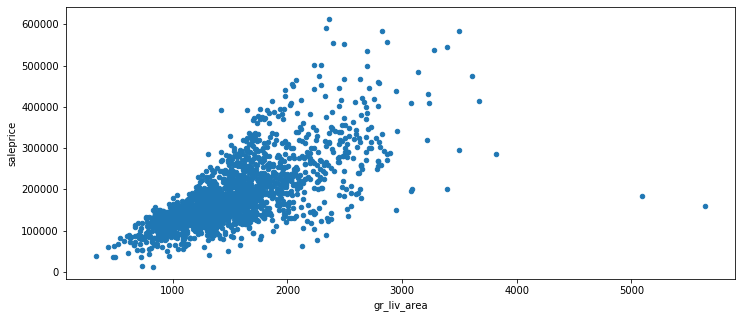

In [39]:
df.plot(x = 'gr_liv_area', y = 'saleprice', kind = 'scatter', figsize = (12, 5));

From the plot I see two houses on the very right which has huge ground living area but rather low sale price. Per author Dean de Cock's suggestion, I am going to drop these rows. 

In [40]:
# credit http://jse.amstat.org/v19n3/decock.pdf
df[df.gr_liv_area > 4000]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice
960,1499,908154235,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,5,3,PConc,5,3,4,6,5644.0,1,0.0,466.0,6110.0,GasA,5,1,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,5,12,Typ,3,4,Attchd,2008.0,3,2.0,1418.0,3,3,1,214,292,0,0,0,480,0,1,2008,New,160000
1885,2181,908154195,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,5,3,PConc,5,3,4,6,4010.0,1,0.0,1085.0,5095.0,GasA,5,1,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,5,15,Typ,2,4,Attchd,2008.0,3,3.0,1154.0,3,3,1,546,484,0,0,0,0,17000,10,2007,New,183850


In [41]:
df.drop([960, 1885], inplace = True)

There is another unusual data that caught my attention earlier, which is in the garage year built. The max is over 2200, which is 200 years ahead of present. That is definitely something I need to fix.

In [42]:
df.garage_yr_blt.describe()

count    2049.000000
mean     1980.280625
std        25.595902
min      1895.000000
25%      1962.000000
50%      1985.000000
75%      2004.000000
max      2207.000000
Name: garage_yr_blt, dtype: float64

In [43]:
df[df.garage_yr_blt == 2207]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice
1699,2261,916384070,20,RL,68.0,8298,Pave,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,None,0.0,4,3,PConc,4,3,3,6,583.0,1,0.0,963.0,1546.0,GasA,5,1,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,5,6,Typ,1,4,Attchd,2207.0,2,2.0,502.0,3,3,1,132,0,0,0,0,0,0,9,2007,New,267300


From above we can see that the house was built in 2006 and last remodeled in 2007. I decide to match the garage built year to the lat remodeled year since it seems more like a typo. 

In [44]:
df.at[1699, 'garage_yr_blt'] = 2007

### Initial EDA

After cleaning up the data, we want to do some initial EDA to get an idea of the big picture and to get some insiprations for feature selections and engineering in the later stage. I want to start by looking at the distribution of our target, the sale price.

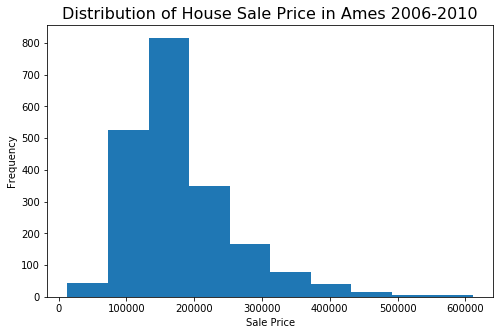

In [45]:
df.hist('saleprice', figsize = (8, 5), grid = False)
plt.title('Distribution of House Sale Price in Ames 2006-2010', fontsize = 16)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.savefig('../charts/saleprice_hist.png');

The distribution is strongly right skewed, which indicates a likely skewed distribution of residuals of my regression model. So I might want to do a log transformation on the target column.

Next I would like to explore the correlation between the variables and sale price.

In [46]:
df.corr()[['saleprice']].sort_values('saleprice', ascending = False)[:11]

,saleprice
saleprice,1.000000
overall_qual,0.803462
gr_liv_area,0.719463
exter_qual,0.715048
kitchen_qual,0.694295
total_bsmt_sf,0.664541
garage_area,0.655458
garage_cars,0.648574
1st_flr_sf,0.648252
bsmt_qual,0.613236


The top 10 strongly correlated variables are shown as above. I notice that the variables are concentrated mainly in quality-related features and sf-related features. So these will be my focus in the feature selection and engineering process. This also makes factual sense, as normally we would assume that the bigger the size of a house is, the higher sale price it would be and that the better quality the higher price. The year built is the 10th on the list. So I would also be interested to look into that.

### Visualizations

The visualization would like to revolve around three areas: square footage-related, location-related, quality-related and age-related.

1. Square footage-related

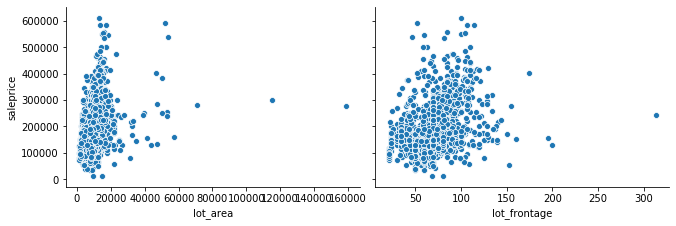

In [47]:
sns.pairplot(df, y_vars = ['saleprice'], x_vars = ['lot_area', 'lot_frontage'], height = 3, aspect = 1.5);

Both lot_area and lot_frontage show very weak corelations with sale price. Consider exclude from the modelings.

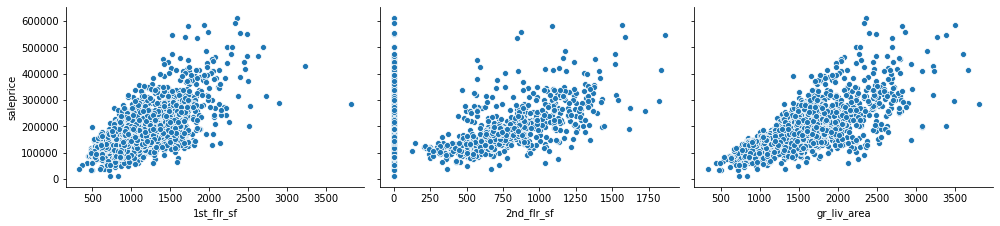

In [48]:
sns.pairplot(df, y_vars = ['saleprice'], x_vars = ['1st_flr_sf','2nd_flr_sf', 'gr_liv_area'], height = 3, aspect = 1.5);

All three varibels show a strong positive correlation with the sale price. However ground living area seems to include the 1st floor and 2nd floor square footage. Therefore it's only necessary to include gr_liv_area in the feature for modeling.

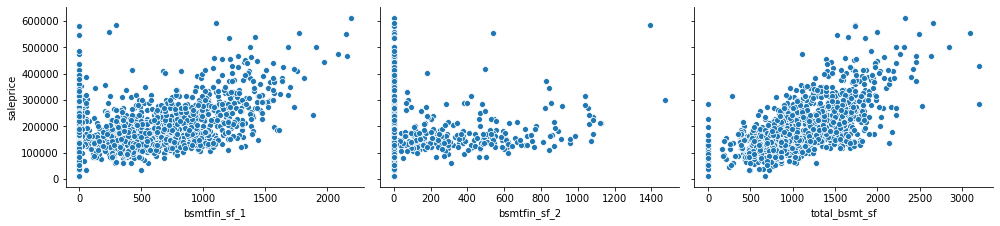

In [49]:
sns.pairplot(df, y_vars = ['saleprice'], x_vars = ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'total_bsmt_sf'], height = 3, aspect = 1.5);

Total basement square footage and finished basement sqaure footage both show a strong positive correlation. However similar to above, only total_bsmt_sf is needed.

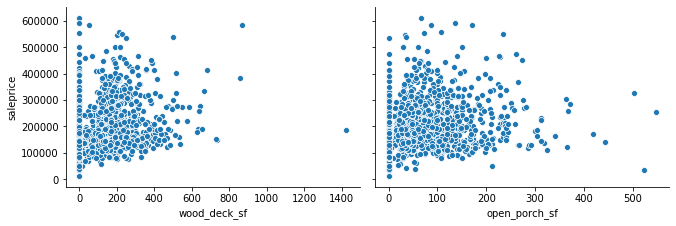

In [50]:
sns.pairplot(df, y_vars = ['saleprice'], x_vars = ['wood_deck_sf', 'open_porch_sf'], height = 3, aspect = 1.5);

Both two variables have a positive correlation with the sale price. However the correlation is not strong. Might consider combine these two features together. 

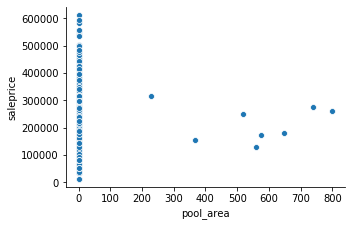

In [51]:
sns.pairplot(df, y_vars = ['saleprice'], x_vars = ['pool_area'], height = 3, aspect = 1.5);

The pool area is not sufficient enough to affect the sale price. Consider exclude from the modeling.

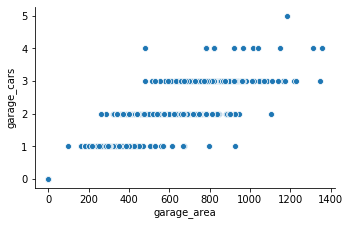

In [52]:
sns.pairplot(df, y_vars = ['garage_cars'], x_vars = ['garage_area'], height = 3, aspect = 1.6);

Garage cars and garage area are strongly correlated. Therefore might consider only include one of the features. Since garage area is also correlated to total square footage, it's better to keep garage cars.

2. Location-related

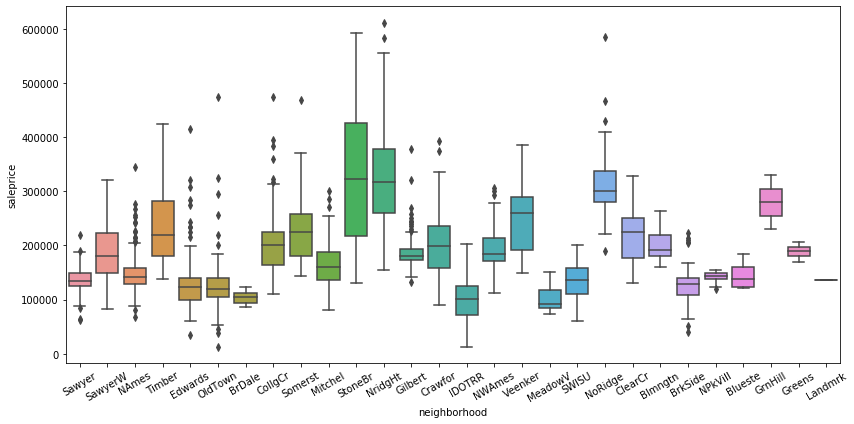

In [66]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = df['neighborhood'], y = df['saleprice'])
plt.xticks(rotation = 30)
plt.tight_layout()
plt.savefig('../charts/nbhd_boxplot.png');

When it comes to house sales, location is the topic one cannot avoid. That's why I think it's important to look at this feature. The most relevant feature from the dataset is neighborhood, which contains 28 unique values. It also has enough variance in data and should be a helpful categorical feature to the modeling.

3. Quality-related

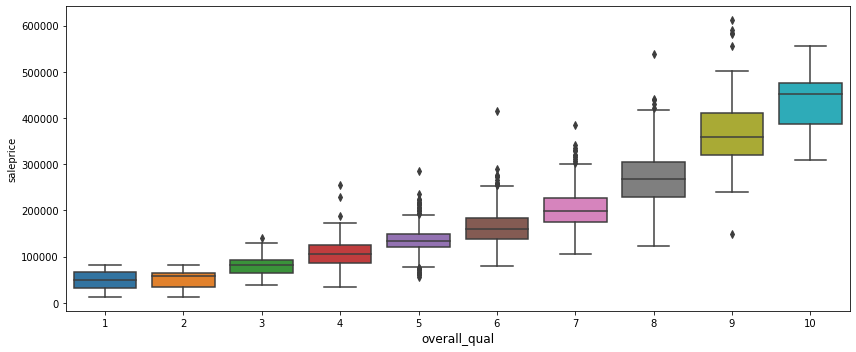

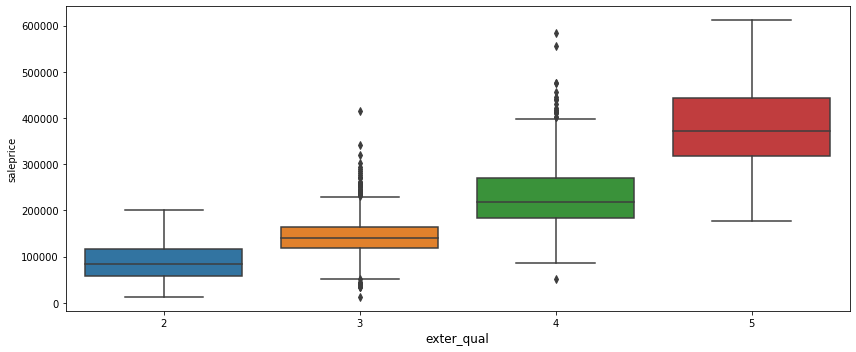

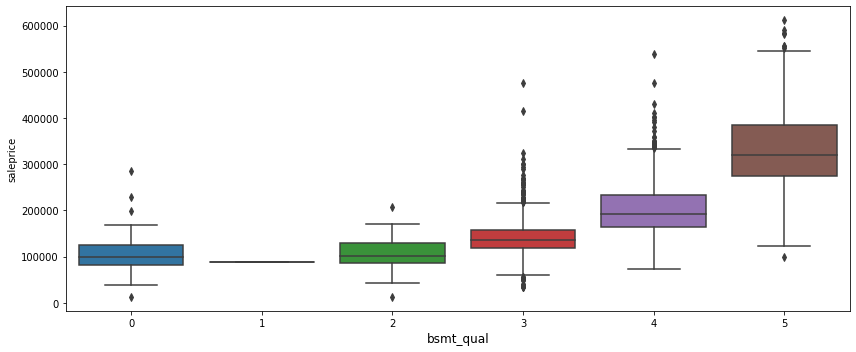

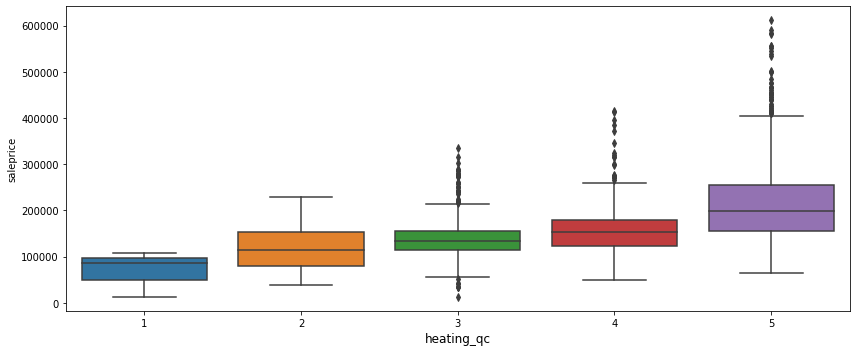

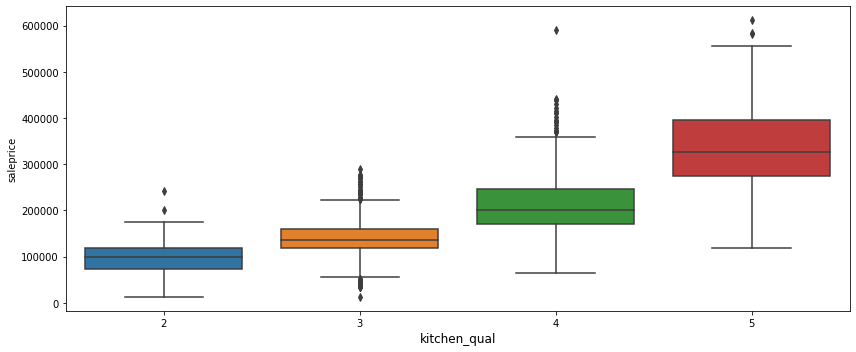

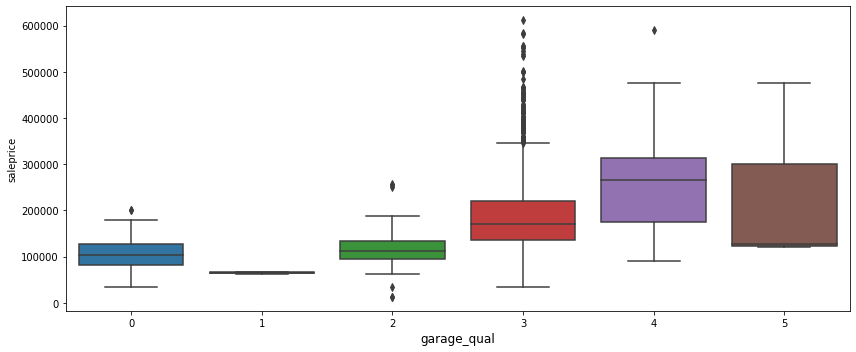

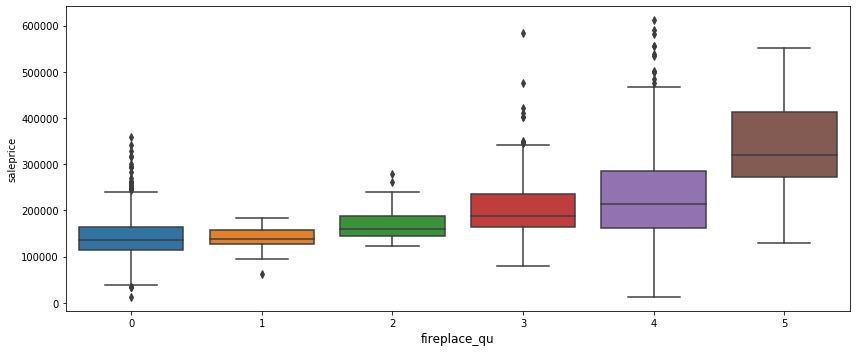

In [61]:
for i in ['overall_qual', 'exter_qual', 'bsmt_qual', 'heating_qc', 'kitchen_qual', 'garage_qual', 'fireplace_qu']:
    plt.figure(figsize = (12,5))
    sns.boxplot(x = df[i], y = df['saleprice'])
    plt.xlabel(i, fontsize = 12)

    plt.tight_layout()
    plt.savefig('../charts/'+i+'.png');

Almost all quality features are positively correlated with saleprice, among which the overall quality, exterior quality, kitchen quality, basement quality and fireplace quality are strongly correlated.

### Initial Feature Engineering

Based on the discovery from EDA, here are some features that I would like to engineer, along with some fine tuning of data cleaning.

1. Engineer age-related features
As I mentioned in the previous sections I would like to look into how age-related features are affecting house prices. The original data has 4 columns that fit my description: year sold, year built, year last remodeled, and garage year built. As the year are not straightforward enough, I would like to convert them into age so that they could be on a similar scale. After my engineer, I will drop those columns except for the year sold, which I would convert to a string datatype and use as a categorical value in my model.

In [55]:
df['age_sold'] = df['yr_sold'] - df['year_built']
df['age_since_remod'] = df['yr_sold'] - df['year_remod/add']
df['age_garage'] = df['yr_sold'] - df['garage_yr_blt']
df['yr_sold'] = df['yr_sold'].astype(str)
df.drop(columns = ['year_built', 'year_remod/add', 'garage_yr_blt'], inplace = True)

df_test['age_sold'] = df_test['yr_sold'] - df_test['year_built']
df_test['age_since_remod'] = df_test['yr_sold'] - df_test['year_remod/add']
df_test['age_garage'] = df_test['yr_sold'] - df_test['garage_yr_blt']
df_test['yr_sold'] = df_test['yr_sold'].astype(str)
df_test.drop(columns = ['year_built', 'year_remod/add', 'garage_yr_blt'], inplace = True)

2. Engineer sqft-related features. As many sqft features have multicollenarity, it makes more sense to combine them so as to reduce the noise for the model. Therefore I'm engineering total sqft, total bathroom and total bedroom by adding related items in the mansor, basement and garage.

In [56]:
df['total_bath'] = df['full_bath'] + df['half_bath'] + df['bsmt_full_bath'] + df['bsmt_half_bath']
df['total_bedroom'] = df['bedroom_abvgr']
df['total_sqft'] = df['gr_liv_area'] + df['total_bsmt_sf'] + df['garage_area']
df.drop(columns = ['full_bath', 'half_bath', 'bsmt_full_bath', 'bsmt_half_bath', 
                   'bedroom_abvgr', 'gr_liv_area', 'total_bsmt_sf', 'garage_area', 
                   '1st_flr_sf', '2nd_flr_sf', 'bsmtfin_sf_2', 'bsmt_unf_sf'], inplace = True)

df_test['total_bath'] = df_test['full_bath'] + df_test['half_bath'] + df_test['bsmt_full_bath'] + df_test['bsmt_half_bath']
df_test['total_bedroom'] = df_test['bedroom_abvgr']
df_test['total_sqft'] = df_test['gr_liv_area'] + df_test['total_bsmt_sf'] + df_test['garage_area']
df_test.drop(columns = ['full_bath', 'half_bath', 'bsmt_full_bath', 'bsmt_half_bath', 
                        'bedroom_abvgr', 'gr_liv_area', 'total_bsmt_sf', 'garage_area', 
                        '1st_flr_sf', '2nd_flr_sf', 'bsmtfin_sf_2', 'bsmt_unf_sf'], inplace = True)

3. Drop features mentioned in the previous sections that consider removal or redundant ones.

In [57]:
df.drop(columns = ['pid', 'lot_frontage', 'lot_area', 'pool_area'], inplace = True)
df_test.drop(columns = ['pid', 'lot_frontage', 'lot_area', 'pool_area'], inplace = True)

### Export Cleaned Datasets

In [58]:
df.shape

(2049, 64)

In [59]:
df_test.shape

(878, 63)

In [60]:
df.to_csv('../datasets/train_clean.csv', index = False)
df_test.to_csv('../datasets/test_clean.csv', index = False)